<a href="https://colab.research.google.com/github/rtajeong/AI_Cluster_MSAC/blob/main/gg_122_CNN_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98_%EB%AA%A8%EB%8D%B8_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 고양이 강아지 구분
## CNN 이용
- 원래 데이터는 25,000개 (고양이 + 강아지)
- 여기서는 2000개로 학습을 시킨다
- 검증은 1000개의 이미지 사용

## 데이터 다운로드

In [2]:
import os, os.path, shutil
# import zipfile
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [1]:
!pip install kaggle

In [3]:
%%writefile kaggle.json
{
  "username": "aaaaa",
  "key": "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
}

Writing kaggle.json


In [4]:
# Kaggle 계정에서 API Token 발급 → kaggle.json 파일 다운로드
# Colab에 kaggle.json 업로드 후 아래 코드 실행:

import os, shutil
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)

# 다운 로드
!pip install kaggle
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
 66% 144M/218M [00:00<00:00, 1.50GB/s]
100% 218M/218M [00:00<00:00, 849MB/s] 


In [5]:
import os, shutil, random

# 1. 압축 풀기
!unzip -q cat-and-dog.zip -d ./cats_and_dogs

# 원본 데이터 경로
original_dataset_dir = './cats_and_dogs/training_set/training_set'

# 2. 새로운 베이스 디렉토리 생성
base_dir = './cats_and_dogs_filtered'
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

for d in [train_dir, validation_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

for d in [train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir, test_cats_dir, test_dogs_dir]:
    os.makedirs(d, exist_ok=True)

# 3. 파일 리스트 가져오기
cat_files = [f for f in os.listdir(os.path.join(original_dataset_dir, 'cats')) if f.endswith('.jpg')]
dog_files = [f for f in os.listdir(os.path.join(original_dataset_dir, 'dogs')) if f.endswith('.jpg')]

# 섞기
random.shuffle(cat_files)
random.shuffle(dog_files)

# 4. train/validation/test 분리 (예: train 1000, val 500, test 500)
def split_and_copy(files, src_dir, train_dest_dir, val_dest_dir, test_dest_dir, train_size=1000, val_size=500, test_size=500):
    for fname in files[:train_size]:
        shutil.copyfile(os.path.join(src_dir, fname), os.path.join(train_dest_dir, fname))
    for fname in files[train_size:train_size+val_size]:
        shutil.copyfile(os.path.join(src_dir, fname), os.path.join(val_dest_dir, fname))
    for fname in files[train_size+val_size:train_size+val_size+test_size]:
        shutil.copyfile(os.path.join(src_dir, fname), os.path.join(test_dest_dir, fname))

split_and_copy(cat_files, os.path.join(original_dataset_dir, 'cats'), train_cats_dir, validation_cats_dir, test_cats_dir)
split_and_copy(dog_files, os.path.join(original_dataset_dir, 'dogs'), train_dogs_dir, validation_dogs_dir, test_dogs_dir)

print("데이터셋 구조가 과거와 동일하게 생성되었다. ✅")

데이터셋 구조가 과거와 동일하게 생성되었다. ✅


In [ ]:
'''
import os
if os.path.exists('./cats_and_dogs_filtered.zip'):
    os.remove('./cats_and_dogs_filtered.zip')

!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O ./cats_and_dogs_filtered.zip


!unzip -q cats_and_dogs_filtered.zip

!apt-get install tree


!tree -d .

base_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
'''

--2025-11-25 05:23:16--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2025-11-25 05:23:16 ERROR 403: Forbidden.



In [6]:
train_cats_dir

'./cats_and_dogs_filtered/train/cats'

## 파일 확인

In [7]:
train_cat_fnames = os.listdir(train_cats_dir)
print (train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print (train_dog_fnames[:10])

['cat.759.jpg', 'cat.1382.jpg', 'cat.58.jpg', 'cat.3830.jpg', 'cat.2038.jpg', 'cat.883.jpg', 'cat.2757.jpg', 'cat.2894.jpg', 'cat.190.jpg', 'cat.476.jpg']
['dog.10.jpg', 'dog.1005.jpg', 'dog.1009.jpg', 'dog.1010.jpg', 'dog.1015.jpg', 'dog.1020.jpg', 'dog.1024.jpg', 'dog.1026.jpg', 'dog.1035.jpg', 'dog.1039.jpg']


In [8]:
print ('total training cat images:', len(os.listdir(train_cats_dir)))
print ('total training dog images:', len(os.listdir(train_dogs_dir)))
print ('total validation cat images:', len(os.listdir(validation_cats_dir)))
print ('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


## 이미지 샘플 확인

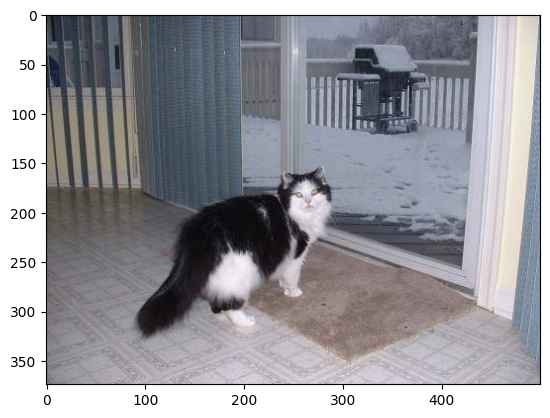

In [9]:
# train_cat_fnames = os.listdir(train_cats_dir)
img_path = os.path.join(train_cats_dir, train_cat_fnames[7])
img = mpimg.imread(img_path)
plt.imshow(img)

In [ ]:
img.shape

## 간단한 CNN을 사용한 모델


In [10]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [11]:
img_width = 150
img_height = 150

datagen = ImageDataGenerator(rescale = 1./255)
train_generator = datagen.flow_from_directory(directory=train_dir,
											   target_size=(img_width,img_height),
											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=20)

validation_generator = datagen.flow_from_directory(directory=validation_dir,
											   target_size=(img_width,img_height),
											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=20)

model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation = 'relu',
                        input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

history = model.fit(
    x=train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=20)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - acc: 0.5289 - loss: 0.6933 - val_acc: 0.5075 - val_loss: 0.6802
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - acc: 0.5746 - loss: 0.6650 - val_acc: 0.6475 - val_loss: 0.6333
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - acc: 0.6760 - loss: 0.6108 - val_acc: 0.6325 - val_loss: 0.6344
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - acc: 0.7256 - loss: 0.5631 - val_acc: 0.6875 - val_loss: 0.5976
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - acc: 0.7243 - loss: 0.5425 - val_acc: 0.6725 - val_loss: 0.5934
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - acc: 0.7440 - loss: 0.4966 - val_acc: 0.6700 - val_loss: 0.6062
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - acc: 0.7894 - loss: 0.4473 - val_acc: 0.7100 - val_loss: 0.5861
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - acc: 0.8079 - loss: 0.4033 - val_acc: 0.7125 - val_loss: 0.5669
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - acc

## 성능 확인

Text(0.5, 1.0, 'Training(--) and validation loss')

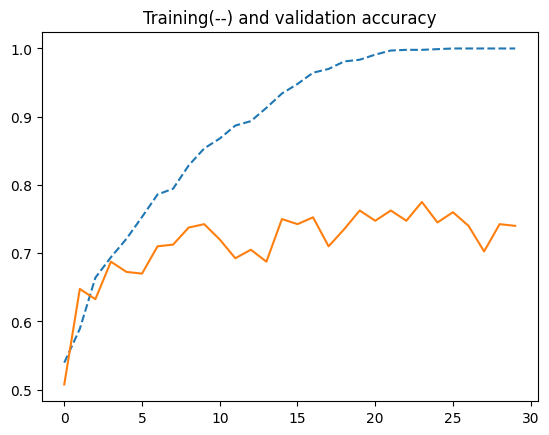

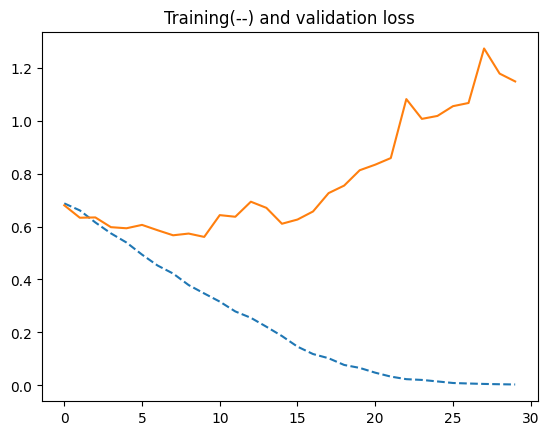

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')


# 데이터 증강 (Augmentation)

In [14]:
train_datagen = ImageDataGenerator(
  rescale= 1./255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
											   target_size=(img_width,img_height),
											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=20)

Found 2000 images belonging to 2 classes.


In [15]:
img_width = 150
img_height = 150

datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = datagen.flow_from_directory(directory=validation_dir,
											   target_size=(img_width,img_height),
											   classes=['dogs','cats'],
											   class_mode='binary',
											   batch_size=20)

model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation = 'relu',
                        input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Found 1000 images belonging to 2 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history = model.fit(
    x=train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - acc: 0.5094 - loss: 0.6949 - val_acc: 0.5810 - val_loss: 0.6901
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 170ms/step - acc: 0.5321 - loss: 0.6907 - val_acc: 0.5000 - val_loss: 0.6897
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - acc: 0.5546 - loss: 0.6861 - val_acc: 0.5970 - val_loss: 0.6781
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 169ms/step - acc: 0.5831 - loss: 0.6785 - val_acc: 0.5350 - val_loss: 0.6882
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - acc: 0.5773 - loss: 0.6748 - val_acc: 0.5740 - val_loss: 0.6717
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step - acc: 0.6130 - loss: 0.6628 - val_acc: 0.6260 - val_loss: 0.6528
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 169ms/step - acc: 0.6027 - loss: 0.6595 - val_acc: 0.6330 - val_loss: 0.6431
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step - acc: 0.6213 - loss: 0.6478 - val_acc: 0.6290 - val_loss: 0.6410
Epoch 9/30
100/100 ━━━━━━━━━━━━━

Text(0.5, 1.0, 'Training(--) and validation loss')

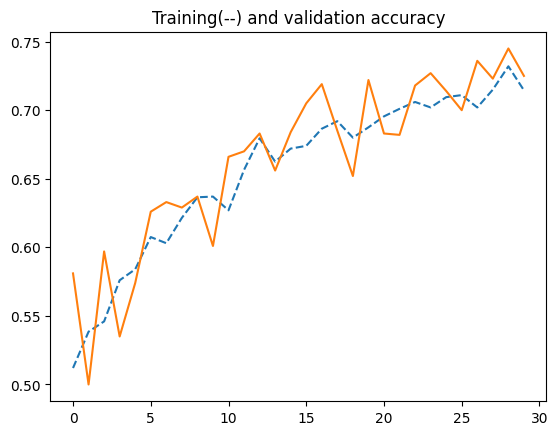

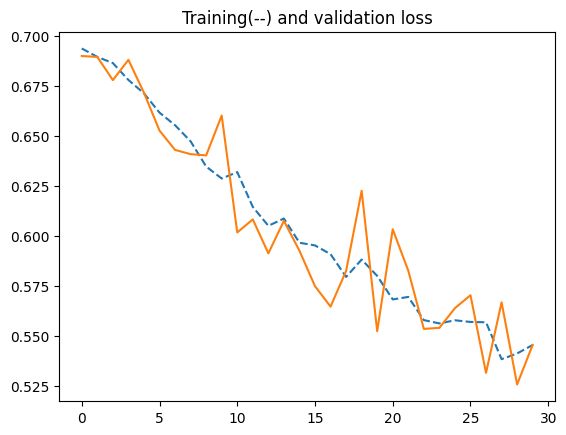

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

- 성능도 좋아지고 과대적합도 줄어 들었다.
- 조금 더 학습을 하면 더 좋아질 수도 있다.